In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_img = path/'images'
path_img.ls()[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_53.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_137.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_191.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_130.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_152.jpg')]

In [0]:
pat = r'/([^/]+)_\d+.jpg$'
src = ImageList.from_folder(path_img).split_by_rand_pct().label_from_re(pat)

In [0]:
bs = 48
def get_data(size,bs,padding_mode = 'reflection'):
  return src.transform(get_transforms(),padding_mode = padding_mode,size=size).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
data = get_data(224,48,padding_mode= 'zeros')

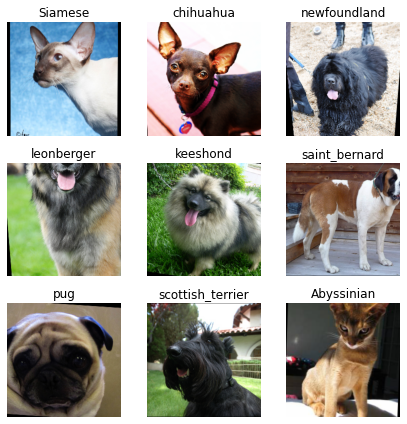

In [25]:
data.show_batch(3,figsize=(6,6))

In [0]:
def _plot(x,y,ax):
  data.train_ds[0][0].show(ax,y=data.train_ds[0][1])


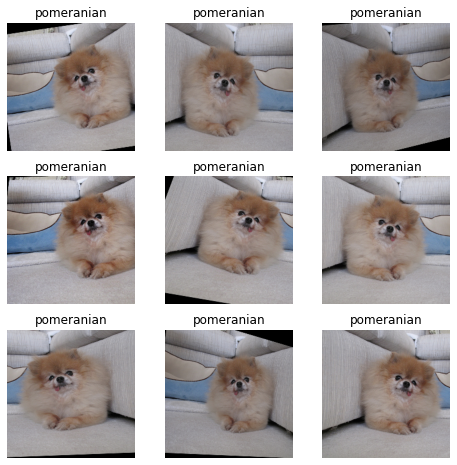

In [27]:
plot_multi(_plot,3,3,figsize=(8,8))

In [0]:
data = get_data(224,48)

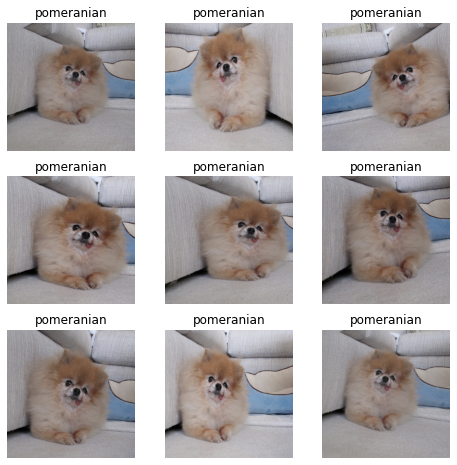

In [46]:
plot_multi(_plot,3,3,figsize=(8,8))

Training


In [0]:
learn = cnn_learner(data,models.resnet34,metrics = accuracy,bn_final=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


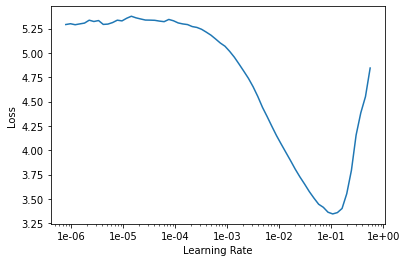

In [48]:
learn.lr_find(end_lr=100)
learn.recorder.plot()


In [50]:
learn.fit_one_cycle(3,slice(1e-02),pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.419277,0.405280,0.911367,01:32
1,0.814113,0.277348,0.920839,01:31
2,0.616212,0.252891,0.926252,01:32


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


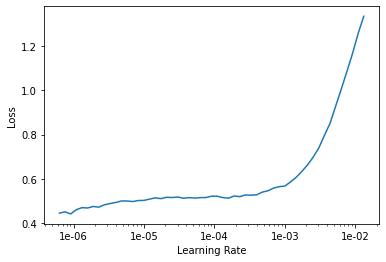

In [51]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(3,slice(1e-06,1e-04),pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.511553,0.264303,0.937077,01:33
1,0.492276,0.255257,0.936401,01:33
2,0.461823,0.238204,0.941137,01:33


In [0]:
learn.save('model-1')

In [0]:
data = get_data(352,bs)
learn.data = data

In [56]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-06,1e-04),pct_start = 0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.483655,0.231500,0.952639,02:39
1,0.460154,0.206751,0.951962,02:44
2,0.424565,0.197430,0.959405,02:43


In [0]:
learn.save('Model')

Convolutions

In [0]:
data = get_data(352,16)

In [60]:
x,y = data.train_ds[0]
x.shape

torch.Size([3, 352, 352])

In [64]:
k = torch.Tensor([[0,5/3,1.],
      [5/3,5/3,-1.],
      [-1.,-1.,-1.]]).expand(1,3,3,3)/6
k,k.shape

(tensor([[[[ 0.0000,  0.2778,  0.1667],
           [ 0.2778,  0.2778, -0.1667],
           [-0.1667, -0.1667, -0.1667]],
 
          [[ 0.0000,  0.2778,  0.1667],
           [ 0.2778,  0.2778, -0.1667],
           [-0.1667, -0.1667, -0.1667]],
 
          [[ 0.0000,  0.2778,  0.1667],
           [ 0.2778,  0.2778, -0.1667],
           [-0.1667, -0.1667, -0.1667]]]]), torch.Size([1, 3, 3, 3]))

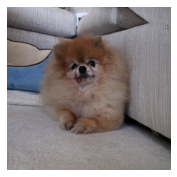

In [68]:
x.show()

In [0]:
conv = F.conv2d(t[None],k)

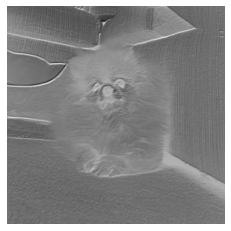

In [72]:
show_image(conv[0],figsize=(4,4))

In [73]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

In [74]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Heatmap

In [0]:
m = learn.model.eval()

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb[0]))
xb = xb.cuda()

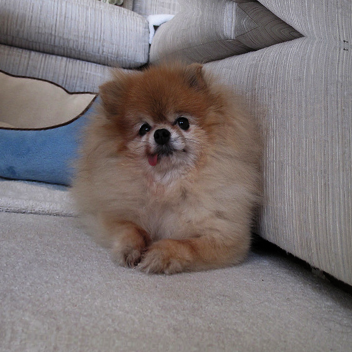

In [77]:
xb_im

In [78]:
xb.shape

torch.Size([1, 3, 352, 352])

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
  with hook_output(m[0]) as hook_a: 
    with hook_output(m[0], grad=True) as hook_g:
      preds = m(xb)
      preds[0,int(cat)].backward()
  return hook_a,hook_g


In [0]:
hook_a,hook_g = hooked_backward()

In [102]:
acts = hook_a.stored[0].cpu()
acts.shape



torch.Size([512, 11, 11])

In [105]:
avg_act = acts.mean(0)
avg_act.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
  _,ax = plt.subplots()
  xb_im.show(ax)
  ax.imshow(hm,alpha=0.5,interpolation='bilinear',cmap='plasma',extent=(0,352,352,0))

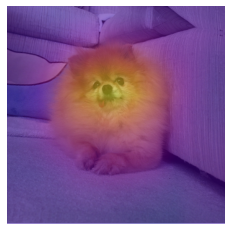

In [123]:
show_heatmap(avg_act)

Gradient-Cam

In [128]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape


(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

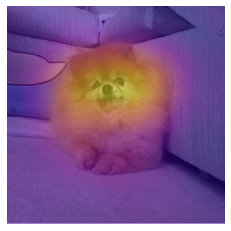

In [132]:
show_heatmap(mult)

In [0]:
x,y = data.valid_ds[5]
xb,_  = data.one_item(x)
xb_img = Image(data.denorm(xb[0]))
xb = xb.cuda()

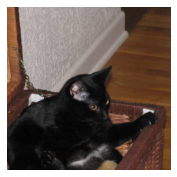

In [138]:
xb_img.show()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

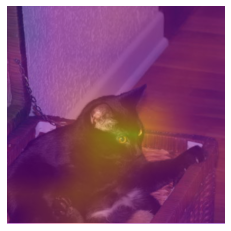

In [146]:
show_heatmap(mult)